# **Stranger Sections Challenge**

## TL;DR

**Eager to get working?** This challenge involves unsupervised segmentation of thin section images. There are 1000 unlabeled images in the dataset your job will be to provide a model that can accurately segment the blobs on the thin sections. You are free to explore any and all methods you see fit to effectively segment these images. There are two types of thin section images, plain light and ultraviolet light images. Ultaviolet light images are used to identify brown blobs that fluoresce a yellow or green color. Each image may contain a variety of blobs to segment. We have provided three examples of satisfactory labels in the `Data` discussion below to serve as a guide. Challenger's work will be evaluated by a panel of judges for accuracy of the label masks (70%), effeciency of the code (25%), and notebook organization/interprability (5%). In addition to the best overall model, challengers will be able to win prizes for honorable mentions.

## Background

Scale is one of the more interesting aspects of science.  Biology investigates genomes and entire ecosystems.  Physics spans quantum forces to gravitational waves from the Big Bang.  Understanding all the different scales for a problem helps us better understand our natural world and how it is changing.  For this challenge, we're asking you to investigate the micrometer scale of geosciences by examining thin sections of rocks and identifying their components.

This challenge aims to build a machine-learning solution to a problem often encountered by machine learning researchers; label scarcity. Challengers will recieve 1000 unlabeled thin section images, and will need to provide a model that is able to correctly segment all blobs on each image.

The fun of this challenge is that there is no one correct way to complete this task. Challengers should focus on their strengths to build a model. If you are an expert with unsupervised clustering, maybe you use `sklearn`'s `kmeans` to create segments with clustering. Maybe you want to test out Meta's SAM model, or better yet one of the offshoots like `segmenteverygrain`. Maybe your background is image processing and you spend most of your time building a pipeline to ingest and enhance the images prior to segmentation.

Since this challenge gives you the freedom to explore different paths, we will be awarding several different prizes for different accomplishments. A total prize pool of $25,000 dollars will be awarded. See `Prizes` section for more information about prize distributions. Whatever approach you choose, all we ask that the solution involves machine learning.

## Data

As highlighted above, the dataset consists of 1000 unlabeled thin section images. Some of these images will will be plain light images and others will be UV light. There will be various blobs on on each thin section image that need to be segmented. Below are 3 examples showing how one might segment the images. The examples show the three types of blobs found on the images. As you'll see, there are potentially more segments on the image than what is currently provided. 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
import time

%matplotlib inline

### Example 1

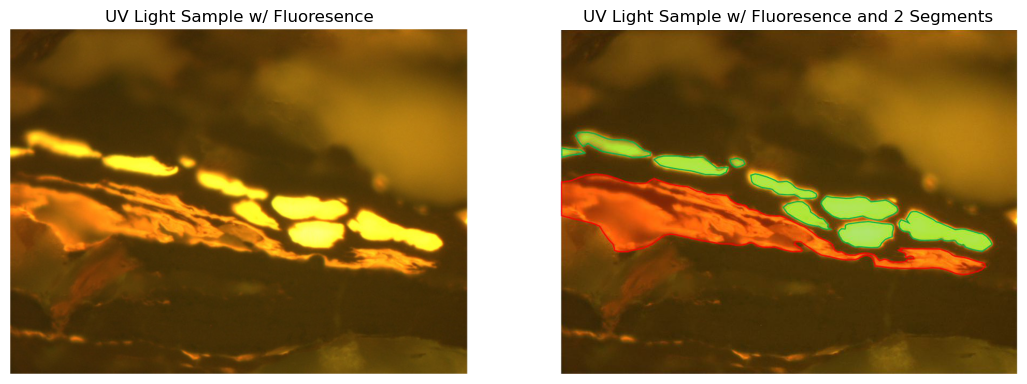

In [9]:
# figure size in inches optional
rcParams['figure.figsize'] = 13 ,10

# read images
img_A = mpimg.imread('images/image1.jpg')
img_B = mpimg.imread('images/image1_label.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('UV Light Sample w/ Fluoresence')
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].title.set_text('UV Light Sample w/ Fluoresence and 2 Segments')
ax[1].imshow(img_B)
ax[1].axis('off')
plt.savefig('sample1.png')
plt.show()

### Example 2

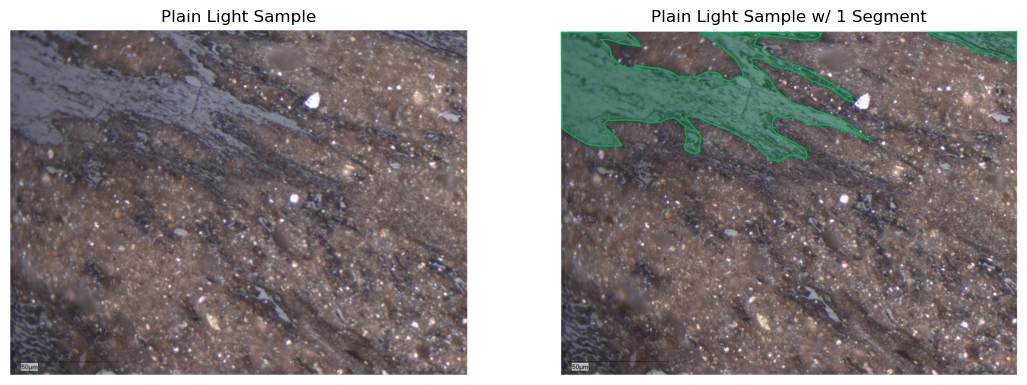

In [10]:
# figure size in inches optional
rcParams['figure.figsize'] = 13 ,10

# read images
img_A = mpimg.imread('images/image2.jpg')
img_B = mpimg.imread('images/image2_label.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('Plain Light Sample')
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].title.set_text('Plain Light Sample w/ 1 Segment')
ax[1].imshow(img_B)
ax[1].axis('off')
plt.savefig('sample2.png')
plt.show()

### Example 3

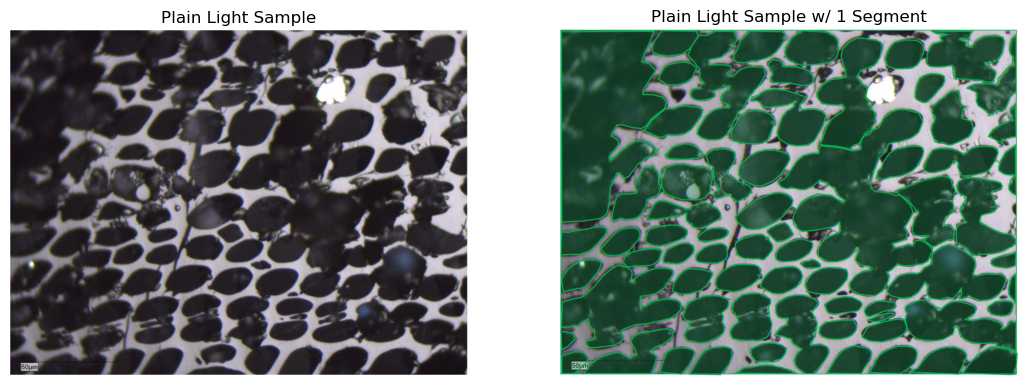

In [11]:
# figure size in inches optional
rcParams['figure.figsize'] = 13 ,10

# read images
img_A = mpimg.imread('images/image3.jpg')
img_B = mpimg.imread('images/image3_label.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('Plain Light Sample')
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].title.set_text('Plain Light Sample w/ 1 Segment')
ax[1].imshow(img_B)
ax[1].axis('off')
plt.savefig('sample3.png')
plt.show()

## Evaluation

Can you build a model to accurately segment all blobs in a thin section image? This is an unstructured competition where your task is to create a Notebook that best addresses the Evaluation criteria below. Submissions should be submitted on the Stranger Sections challenge page and will be judged by Xeek based on how well they address:

* **Image Segments (70%)**
    * How well are the images segmented? 
    * If there are multiple blobs are they broken out into different segments? 
    * Is the entire blob segmented? 
    * If there are metrics available, did the author provide a way of assessing the performance and accuracy of their solution? - Silhouette Score, ARI, Loss Function
* **Code efficiency (25%)**
    * What is the model runtime? *Note: If a clear winner cannot be determined visually, judges will look at code performance to determine a winner.*
* **Notebook Presentation (5%)**
    * Does the notebook contain data visualizations that help to communicate the author’s main points? 
    * Is the code documented in a way that makes it easy to understand and reproduce? 
    * Were all external sources of data made public and cited appropriately?

## Code

In [50]:
%%time

#-------------------

#### YOUR CODE GOES HERE ###

#-------------------

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs
